# A simple example of Q-Learning with automatic hyperparameter search
## Using OpenAI Gym and Hyperopt
## Environement: FrozenLake

In [1]:
%reset -f

In [2]:
#Environment and learning
import gym #Gives the environment
import numpy as np #For some simple math


#Visualization
from tqdm import tqdm #visualize progress
import matplotlib.pyplot as plt #plot function
import seaborn as sns #makes pretty plots
from IPython.display import clear_output #Gives you online output during learning without flooding the screen
np.set_printoptions(precision=2, suppress=True) #nice output

#Data handling
import pandas as pd #to handle the learning data
import random #it's boring if everything is certain isn't it?
import pickle #snacking time ... ok just a way to store our results

#Used for parameter optimization
from hyperopt import fmin, tpe, space_eval
from hyperopt import hp , Trials, STATUS_OK
import time

#To create a mixed search algorithm
from hyperopt import anneal, rand, tpe, mix
from functools import partial

In [3]:
env = gym.make('FrozenLake-v0')

In [4]:
#Prints the current behavior
def current_policy(Q):
    action_space_desc = {
        0 : 'LEFT',
        1: 'DOWN',
        2: 'Right',
        3: 'Up'
    }
    env.render()
    print(\
          "Current best actions:", np.array([action_space_desc[i] for i in np.argmax(Q, axis = 1)]).reshape([4,4]), \
          "Average return:",evaluate(Q), sep="\n")

In [5]:
def evaluate(Q_Table, evaluations = 5):
    """Evaluates the Q-Table using a greedy policy"""
    
    #Check if you actually got a Q-Table 
    if type(Q_Table) is type(None):
        raise Exception('Q Table is None:',Q_Table)

    result = []
    r=0
    
    for i in range(evaluations): #reavluate 10 times
        reward = 0.
        for episode in range(100): #calculate 100-episode average reward
            s = env.reset()
            
            done = False
            while not done:
                a = np.argmax(Q_Table[s,:]) # greedy policy               
                s, r, done , info = env.step(a)
                reward += r #Just necessary if you change your reward function, otherwise you can move it to "done"
                if done:
                    break
        result.append(reward/100.)    

    return np.average(result)



# Implementation of the actual learning algorithm (Q-Learning)

In [6]:
def train_episodes(alpha = 0.1, gamma =0.9, epsilon= 0.2, num_episodes = 1000, init='zero', Q = None):

    states = env.observation_space.n
    actions = env.action_space.n
    
    num_steps = 100

    reward=[]
    
    #Decide if you want to initialize your Q-Table with zeros or a normal distribution
    if type(Q) is type(None):
        if init=='zero':
            Q = np.zeros([states,actions], dtype=float) 
        else:
            Q = np.random.uniform(size=states*actions).reshape((states,actions))

    for episode in range(num_episodes):
        steps = 0
        done = False
        rewards_current_episode = 0
        s = env.reset()
        while not done:

            if steps > num_steps:
                break

            steps +=1

            if random.uniform(0,1) < epsilon:
                a = env.action_space.sample()
            else:
                a = np.argmax(Q[s,:])

            s1 , r, done, info = env.step(a)

            Q[s,a] = Q[s,a] + alpha*(r + gamma*(np.max(Q[s1,:]) - Q[s,a]))

            s = s1
            rewards_current_episode += r

            if done:
                reward.append(rewards_current_episode)
                break

    env.reset()

    return (Q , reward)


    

In [7]:
def train_model(alpha = 0.1, gamma =0.9, epsilon= 0.2, num_episodes = 5000, init='zero'):
    best_score = [0]
    best_Q = None
    Q = None
    score = 0
    
    number_of_episode_before_eval = 500

    for _ in tqdm(range(int(num_episodes/number_of_episode_before_eval))):
        
        Q , reward = train_episodes(alpha, gamma, epsilon, number_of_episode_before_eval, init, Q)
        
        score = np.average(evaluate(Q))
        
        if  (score != 0) and (score > best_score[-1]):
            best_score.append(score)
            best_Q = np.copy(Q)
            
    if type(best_Q) is type(None):
        if type(Q) is type(None):
            raise Exception("All Q's are None",Q, best_Q)
        return Q, score
    else:
        tmp = np.average(evaluate(best_Q))
        if  tmp == 0:
            raise Exception("Best Score 0 ????")
        return best_Q, best_score
        
    

In [8]:
num_episodes = 5000
Q = np.array([])
reward = 0.
while np.count_nonzero(Q) < 3: #Just ensure that we learned a bit (and didn't accidentally pick a trial without any progress)
    Q, reward = train_model(num_episodes=num_episodes)
    tmp = np.average(evaluate(Q))
    print("Average return:",evaluate(Q,evaluations=3))


100%|██████████| 10/10 [00:06<00:00,  1.29it/s]


Average return: 0.6933333333333334


In [9]:
reward

[0, 0.506, 0.614, 0.6380000000000001, 0.7, 0.714]

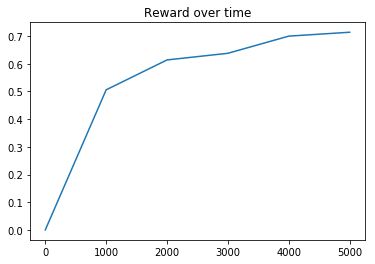

In [10]:
trial = np.linspace(0,num_episodes,len(reward))
plt.title("Reward over time")
plt.plot(trial,reward)

In [11]:
def objective(space):
    alpha = space['alpha']
    gamma = space['gamma']
    epsilon = space['epsilon']
    num_episodes = int(space['num_episodes'])
    init = space['init']

    Q, reward = train_model(alpha , gamma , epsilon , num_episodes,init)

    loss = 1. - np.average(evaluate(Q))
    return {
        'loss' : loss,
        'status' : STATUS_OK,
        'eval_time': time.time(),
        'Q_Table' : Q,
        'reward' : reward
    }

In [12]:
space = {'alpha': hp.uniform('alpha',0.,1.), \
         'gamma' : hp.uniform('gamma',0.,1.), \
         'epsilon':hp.uniform('epsilon',0.,1.),\
         'init' : hp.choice('init',['zero','normal']), \
         'num_episodes' : hp.uniform('num_episodes',1000,10000)
        }

mix_algo = partial(mix.suggest, p_suggest=[
    (0.05, rand.suggest),
    (0.75, tpe.suggest),
    (0.20, anneal.suggest)])

In [13]:
def load_trials():
    try:
        trials = pickle.load( open( "trials.pickle", "rb" ) )
        print("Trials file found with", len(trials),"entries")
        if len(trials) == 0:
            trials = Trials()
    except:
        trials = Trials()
        print("No trials found. Create new trials file")

    return trials
def save_trials():
    print("Save", len(trials), "runs")
    pickle.dump(trials,open('trials.pickle', 'wb'))

In [14]:
#Sample
#import hyperopt
#print(hyperopt.pyll.stochastic.sample(space))

In [15]:
#Train as long as you want but let it run for at least 10 episodes otherwise you may experience issues with seaborn later on

trials = load_trials()
best = []
try:

    while True:
        max_trials = len(trials)+1
        print("Doing number:", max_trials)
        best.append(fmin(objective, space, algo=mix_algo, max_evals=max_trials, trials=trials))
        if max_trials % 10 == 0:
            save_trials()
        clear_output()

except KeyboardInterrupt:
    print("Analysis done...")
best = best[-1]

  0%|          | 0/9 [00:00<?, ?it/s]

Doing number: 41


 89%|████████▉ | 8/9 [00:02<00:00,  2.43it/s]

Analysis done...


In [16]:
best

{'alpha': 0.2805474090517472,
 'epsilon': 0.6333534325403999,
 'gamma': 0.4902613143744966,
 'init': 0,
 'num_episodes': 6204.271366912265}

In [17]:
save_trials()

Save 41 runs


In [18]:
lst = []
all = []
for x in trials.trials: 
    if x['result']['status']=='ok':
        for y in x['misc']['vals']:
            lst.append(x['misc']['vals'][y][0])
        lst.append(x['result']['loss'])
    all.append(lst)
    lst = []

In [19]:
pd_trials = pd.DataFrame(all)
pd_trials.columns = ['alpha','epsilon','gamma','init','num_episodes','loss']
pd_trials['init'] = pd_trials['init'].apply(lambda x : 'zero' if x ==0 else 'normal' )
pd_trials = pd_trials.dropna()
pd_trials.sample(5)


,alpha,epsilon,gamma,init,num_episodes,loss
2,0.626929,0.860631,0.359106,zero,8632.439373,0.258
3,0.771369,0.101548,0.284905,normal,4414.748520,0.268
4,0.170318,0.772240,0.755645,normal,4314.696099,0.252
33,0.259562,0.792437,0.741072,zero,5331.053512,0.274
1,0.806169,0.743810,0.796380,normal,7187.837163,0.646


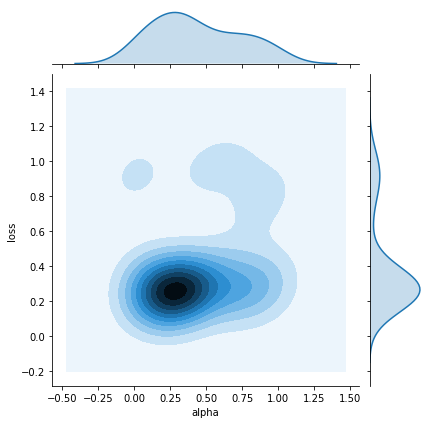

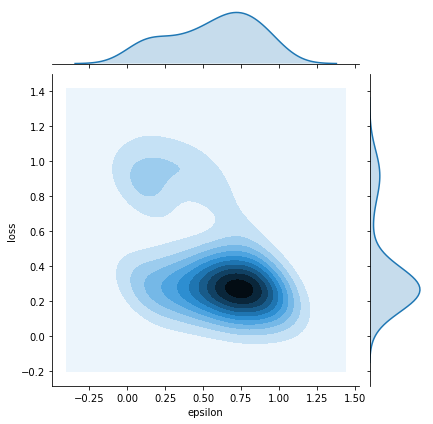

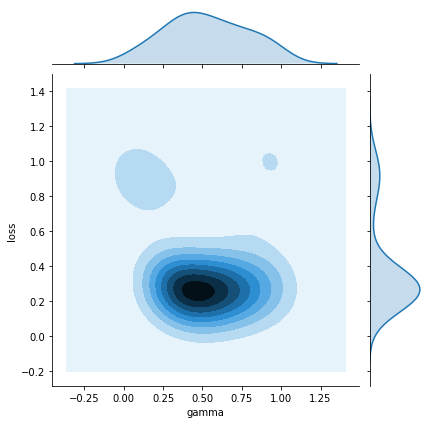

In [20]:
sns.jointplot("alpha", "loss", data=pd_trials, kind='kde' )
sns.jointplot("epsilon", "loss", data=pd_trials, kind='kde')
sns.jointplot("gamma", "loss", data=pd_trials, kind='kde')

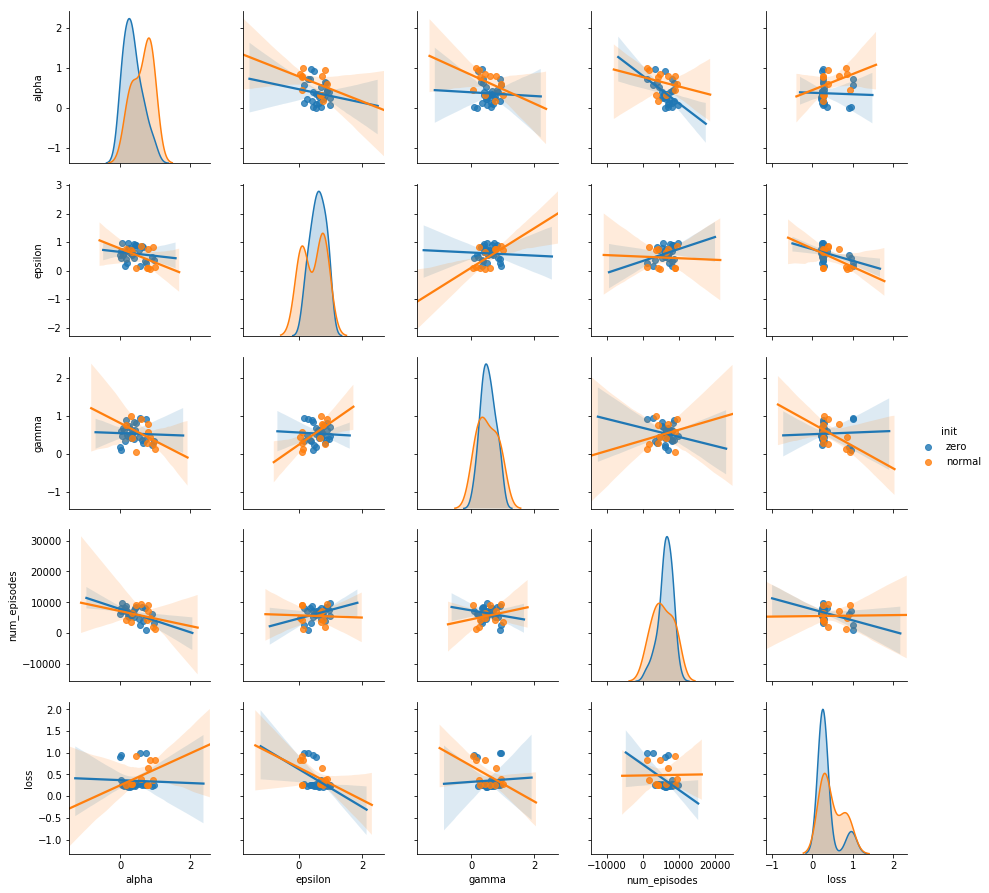

In [21]:
sns.pairplot(data=pd_trials,kind="reg",hue="init")

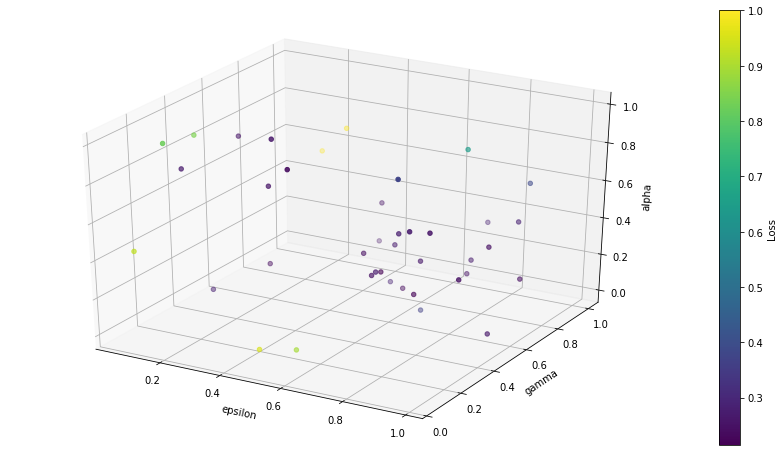

In [22]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(15,8))
ax = fig.add_subplot(111, projection='3d')
ax.set_zlabel('alpha')
ax.set_ylabel('gamma')
ax.set_xlabel('epsilon')
pnt3d = ax.scatter(pd_trials['epsilon'],pd_trials['gamma'],pd_trials['alpha'],c=pd_trials['loss'])
cbar=plt.colorbar(pnt3d)
cbar.set_label("Loss")
plt.show()

In [23]:
best = space_eval(space, best)

In [24]:
best

{'alpha': 0.2805474090517472,
 'epsilon': 0.6333534325403999,
 'gamma': 0.4902613143744966,
 'init': 'zero',
 'num_episodes': 6204.271366912265}

In [25]:
_Q = objective(best)['Q_Table']

100%|██████████| 12/12 [00:07<00:00,  1.37it/s]


In [26]:
np.average(evaluate(_Q,evaluations=10))

0.726